
# Asking Humans for Help: Customizing State in LangGraph

- Author: [Hwayoung Cha](https://github.com/forwardyoung)
- Design: []()
- Peer Review: []()
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

## Overview

This tutorial demonstrates how to extend a chatbot using LangGraph by adding a **"human" node**, allowing the system to optionally ask humans for help. It introduces state customization with an "ask_human" flag and shows how to handle interruptions and manual state updates. The tutorial also covers graph visualization, conditional logic, and integrating tools like web search and human assistance.

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Setting Up the Node to Ask Humans for Help](#setting-up-the-node-to-ask-humans-for-help)
- [Setting Up the Human Node](#setting-up-the-human-node)

## References

- [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/)

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial


[notice] A new release of pip is available: 23.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langgraph",
        "langchain_core",
        "langchain_openai",
        "langchain_community"
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGSMITH_TRACING_V2": "true",
        "LANGSMITH_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_PROJECT": "", # set the project name same as the title
        "TAVILY_API_KEY": ""
    }
)

Environment variables have been set successfully.


You can alternatively set OPENAI_API_KEY in .env file and load it.

[Note] This is not necessary if you've already set OPENAI_API_KEY in previous steps.

In [4]:
# Configuration file to manage API keys as environment variables
from dotenv import load_dotenv

# Load API key information
load_dotenv(override=True)

True

## Setting Up the Node to Ask Humans for Help

Extends the `State` class to include an `ask_human` flag and defines the `HumanRequest` tool schema using `TypedDict` and `BaseModel`. This allows the chatbot to formally request human assistance when needed, adding flexibility to its decision-making process.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.tools import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

This time, we will add a state (`ask_human`) to determine whether the chatbot should ask a human for help during the conversation.

In [6]:
class State(TypedDict):
    # List for messages
    messages: Annotated[list, add_messages]
    # State to determine whether to ask a human for help
    ask_human: bool

We define the schema for the `human` request.

In [7]:
from pydantic import BaseModel


class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str

Next, we define the chatbot node. 
The key modification here is that the chatbot will toggle the `ask_human` flag if it calls the `RequestAssistance` flag.

In [8]:
from langchain_openai import ChatOpenAI

# Add tools
tool = TavilySearchResults(max_results=3)

# Add the list of tools (including the HumanRequest tool)
tools = [tool, HumanRequest]

# Add the LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    # Generate a response using the LLM tool calls
    response = llm_with_tools.invoke(state["messages"])

    # Initialize the ask_human flag
    ask_human = False

    # If there is a tool call and its name is 'HumanRequest'
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # Return the messages and the ask_human state
    return {"messages": [response], "ask_human": ask_human}

Next, we create the graph builder and add the `chatbot` and `tools` nodes to the graph, as before.

In [9]:
# Initialize the state graph
graph_builder = StateGraph(State)

# Add the chatbot node
graph_builder.add_node("chatbot", chatbot)

# Add the tools node
graph_builder.add_node("tools", ToolNode(tools=[tool]))

## Setting Up the Human Node

Next, we create the `human` node. 

This node primarily serves as a placeholder to trigger an interrupt in the graph. If the user does not manually update the state during the `interrupt`, the LLM will insert a tool message to indicate that the human was asked for help but did not respond.

This node also resets the `ask_human` flag to ensure the graph does not revisit the node unless another request is made.

> Reference Image

![](./assets/08-langgraph-state-customization.png)

In [10]:
from langchain_core.messages import AIMessage, ToolMessage

# Function to create a response message (for generating ToolMessage)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# Human node processing
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # If there is no response from the human
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Add new messages
        "messages": new_messages,
        # Reset the flag
        "ask_human": False,
    }

# Add the human node to the graph
if "human" not in graph_builder.nodes: 
    graph_builder.add_node("human", human_node)

Next, we define the conditional logic.

The `select_next_node` function routes the path to the `human` node if the flag is set. Otherwise, it uses the prebuilt `tools_condition` function to select the next node.

The `tools_condition` function simply checks if the `chatbot` used `tool_calls` in the response message.

If so, it routes to the `action` node. Otherwise, it ends the graph.

In [11]:
from langgraph.graph import END

# Function to select the next node
def select_next_node(state: State):
    # Check if the chatbot should ask a human
    if state["ask_human"]:
        return "human"
    # Otherwise, follow the same path as before
    return tools_condition(state)

# Add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

Finally, we connect the edges and compile the graph.

In [12]:
# Add edge: from 'tools' to 'chatbot'
graph_builder.add_edge("tools", "chatbot")

# Add edge: from 'human' to 'chatbot'
graph_builder.add_edge("human", "chatbot")

# Add edge: from START to 'chatbot'
graph_builder.add_edge(START, "chatbot")

# Initialize memory storage
memory = MemorySaver()

# Compile the graph: use memory checkpointing
graph = graph_builder.compile(
    checkpointer=memory,
    # Set interrupt before 'human'
    interrupt_before=["human"],
)

Let's visualize the graph.

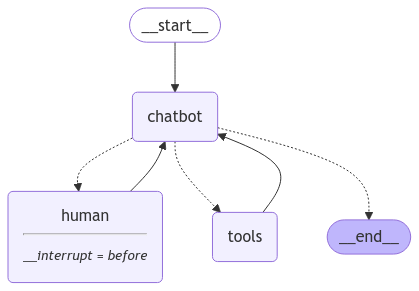

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

The `chatbot` node behaves as follows:

- The chatbot can ask a human for help (chatbot->select->human)
- It can call a search engine tool (chatbot->select->action)
- Or it can respond directly (chatbot->select-> **end** ).

Once an action or request is made, the graph switches back to the `chatbot` node to continue the task.

In [14]:
# user_input = "I need expert help to build this AI agent. Please search for an answer." (Case where it performs a web search instead of asking a human)
user_input = "I need expert help to build this AI agent. Can you request assistance?"

# Config setup
config = {"configurable": {"thread_id": "1"}}

# Stream or call the second positional argument as configuration
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        # Pretty print the last message
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need expert help to build this AI agent. Can you request assistance?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_wx9Kdr8GFUqbPLz0WYIDMDfn)
 Call ID: call_wx9Kdr8GFUqbPLz0WYIDMDfn
  Args:
    request: I need assistance in building an AI agent. I'm looking for guidance on the design, implementation, and best practices for developing an effective AI agent.


**Notice:** The `LLM` has called the provided "`HumanRequest`" tool, and an interrupt has been set. Let's check the graph state.

In [15]:
# Create a snapshot of the graph state
snapshot = graph.get_state(config)

# Access the next snapshot state
snapshot.next

('human',)

The graph state is actually **interrupted** before the `'human'` node. In this scenario, you can act as the "expert" and manually update the state by adding a new `ToolMessage` with your input.

To respond to the chatbot's request, follow these steps:

1. Create a `ToolMessage` containing your response. This will be passed back to the `chatbot`.
2. Call `update_state` to manually update the graph state.

In [16]:
# Extract the AI message
ai_message = snapshot.values["messages"][-1]

# Create a human response
human_response = (
    "Experts are here to help! We highly recommend checking out LangGraph for building your agent. "
    "It is much more stable and scalable than a simple autonomous agent. "
    "You can find more information at https://wikidocs.net/233785."
)

# Create a tool message
tool_message = create_response(human_response, ai_message)

# Update the graph state
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd995f-bb3e-6210-8002-424fec5dff73'}}

You can check the state to confirm that the response has been added.

In [17]:
# Get the message values from the graph state
graph.get_state(config).values["messages"]

[HumanMessage(content='I need expert help to build this AI agent. Can you request assistance?', additional_kwargs={}, response_metadata={}, id='68c43e31-4350-4062-8d81-b7547f24c727'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wx9Kdr8GFUqbPLz0WYIDMDfn', 'function': {'arguments': '{"request":"I need assistance in building an AI agent. I\'m looking for guidance on the design, implementation, and best practices for developing an effective AI agent."}', 'name': 'HumanRequest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 151, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-12747fa0

Next, we **resume** the graph by passing `None` as the input.

In [18]:
# Generate an event stream from the graph
events = graph.stream(None, config, stream_mode="values")

# Process each event
for event in events:
    # Print the last message if messages are present
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

Experts are here to help! We highly recommend checking out LangGraph for building your agent. It is much more stable and scalable than a simple autonomous agent. You can find more information at https://wikidocs.net/233785.
================================= Tool Message =================================

Experts are here to help! We highly recommend checking out LangGraph for building your agent. It is much more stable and scalable than a simple autonomous agent. You can find more information at https://wikidocs.net/233785.
================================== Ai Message ==================================

I've requested assistance, and the experts recommend checking out LangGraph for building your AI agent. It's noted to be more stable and scalable than a simple autonomous agent. You can find more information [here](https://wikidocs.net/233785).


Finally, let's check the final result.

In [19]:
# Check the final state
state = graph.get_state(config)

# Print the messages step by step
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

I need expert help to build this AI agent. Can you request assistance?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_wx9Kdr8GFUqbPLz0WYIDMDfn)
 Call ID: call_wx9Kdr8GFUqbPLz0WYIDMDfn
  Args:
    request: I need assistance in building an AI agent. I'm looking for guidance on the design, implementation, and best practices for developing an effective AI agent.
================================= Tool Message =================================

Experts are here to help! We highly recommend checking out LangGraph for building your agent. It is much more stable and scalable than a simple autonomous agent. You can find more information at https://wikidocs.net/233785.
================================== Ai Message ==================================

I've requested assistance, and the experts recommend checking out LangGraph for building your AI agent